# F1 Pit-Stop Strategy Analysis – Bahrain Grand Prix

This notebook analyses lap time evolution and tyre behaviour for the Bahrain Grand Prix.
The focus is on establishing a baseline understanding of tyre degradation trends and
pit-stop timing under high thermal stress conditions.

### Objectives
- Analyse lap time progression across stints
- Study tyre degradation characteristics on a high-abrasion track
- Identify candidate pit windows using regression-based trends

### Notes
- Bahrain is treated as a high-degradation, high-temperature circuit
- Models in this phase prioritise interpretability over complexity
- Results serve as a reference baseline for later strategy optimisation


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/top3_data.csv'

In [ ]:
import pandas as pd

df = pd.read_csv(file_path)

In [ ]:
df.head()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   year                     70 non-null     int64  
 1   race_name                70 non-null     object 
 2   no_of_laps               70 non-null     int64  
 3   driver_code              70 non-null     object 
 4   team_name                70 non-null     object 
 5   qualifying_position      70 non-null     int64  
 6   finishing_position       70 non-null     int64  
 7   pitstop_count            70 non-null     int64  
 8   actual_pit_lap           70 non-null     int64  
 9   starting_tyre            70 non-null     object 
 10  tyre_after_pit           70 non-null     object 
 11  avg_lap_time_before_pit  70 non-null     float64
 12  avg_lap_time_after_pit   70 non-null     float64
 13  lap_times_5_before_pit   70 non-null     object 
 14  lap_times_5_after_pit    70 

,year,no_of_laps,qualifying_position,finishing_position,pitstop_count,actual_pit_lap,avg_lap_time_before_pit,avg_lap_time_after_pit
count,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000
mean,2022.485714,55.271429,4.771429,6.071429,1.957143,14.914286,100.829410,99.619144
std,1.126015,3.064152,3.612263,5.580300,0.788242,5.252309,9.572155,7.447299
min,2021.000000,51.000000,1.000000,1.000000,1.000000,2.000000,88.749308,88.575375
25%,2021.250000,51.000000,2.000000,2.000000,1.000000,12.000000,91.550609,92.982994
50%,2022.500000,57.000000,4.000000,4.000000,2.000000,14.000000,99.678894,98.469138
75%,2023.000000,58.000000,6.000000,7.750000,2.000000,17.000000,108.216439,107.194976
max,2024.000000,58.000000,18.000000,19.000000,4.000000,34.000000,147.951000,114.170364


In [ ]:
df['race_name'].unique()

array(['Bahrain Grand Prix', 'Azerbaijan Grand Prix',
       'Abu Dhabi Grand Prix'], dtype=object)

In [ ]:
import pandas as pd

df = pd.read_csv(file_path)

# Convert datatypes
df = df.astype({
    'year': 'int64',
    'race_name': 'string',
    'no_of_laps': 'int64',
    'driver_code': 'string',
    'team_name': 'string',
    'pitstop_count': 'int64',
    'actual_pit_lap': 'int64',
    'starting_tyre': 'string',
    'tyre_after_pit': 'string',
    'avg_lap_time_before_pit': 'float64',
    'avg_lap_time_after_pit': 'float64',
    'lap_times_5_before_pit': 'string',
    'lap_times_5_after_pit': 'string'
})

# nullable integer types for columns that may have missing data
df['qualifying_position'] = df['qualifying_position'].astype('Int64')
df['finishing_position'] = df['finishing_position'].astype('Int64')

print(df.dtypes)

year                                int64
race_name                  string[python]
no_of_laps                          int64
driver_code                string[python]
team_name                  string[python]
qualifying_position                 Int64
finishing_position                  Int64
pitstop_count                       int64
actual_pit_lap                      int64
starting_tyre              string[python]
tyre_after_pit             string[python]
avg_lap_time_before_pit           float64
avg_lap_time_after_pit            float64
lap_times_5_before_pit     string[python]
lap_times_5_after_pit      string[python]
dtype: object


In [ ]:
print(df.isna().sum())


year                       0
race_name                  0
no_of_laps                 0
driver_code                0
team_name                  0
qualifying_position        0
finishing_position         0
pitstop_count              0
actual_pit_lap             0
starting_tyre              0
tyre_after_pit             0
avg_lap_time_before_pit    0
avg_lap_time_after_pit     0
lap_times_5_before_pit     0
lap_times_5_after_pit      0
dtype: int64


In [ ]:
import numpy as np

# Calculate derived features
df['lap_time_diff'] = df['avg_lap_time_after_pit'] - df['avg_lap_time_before_pit']
df['pit_effectiveness'] = df['lap_time_diff'] / df['pitstop_count']

# Tyre compound change
df['tyre_change'] = np.where(df['starting_tyre'] != df['tyre_after_pit'], 1, 0)

# Position gain/loss
df['position_gain'] = df['qualifying_position'] - df['finishing_position']

# Undercut success flag
df['is_undercut_successful'] = (df['lap_time_diff'] < 0) & (df['position_gain'] > 0)

# Normalized performance gain
df['avg_lap_improvement_ratio'] = (
    (df['avg_lap_time_before_pit'] - df['avg_lap_time_after_pit'])
    / df['avg_lap_time_before_pit']
)

# Tyre strategy score (SOFT > MEDIUM > HARD)
def tyre_score(before, after):
    mapping = {'SOFT': 3, 'MEDIUM': 2, 'HARD': 1}
    if pd.isna(before) or pd.isna(after):
        return np.nan
    return mapping.get(before, 0) - mapping.get(after, 0)

df['tyre_strategy_score'] = df.apply(
    lambda row: tyre_score(row['starting_tyre'], row['tyre_after_pit']), axis=1
)

# Check new columns
df.head()

,year,race_name,no_of_laps,driver_code,team_name,qualifying_position,finishing_position,pitstop_count,actual_pit_lap,starting_tyre,...,avg_lap_time_after_pit,lap_times_5_before_pit,lap_times_5_after_pit,lap_time_diff,pit_effectiveness,tyre_change,position_gain,is_undercut_successful,avg_lap_improvement_ratio,tyre_strategy_score
0,2021,Bahrain Grand Prix,56,HAM,Mercedes,2,1,2,13,MEDIUM,...,95.877884,"96.075,96.148,96.082,96.143,96.507","115.006,94.057,95.104,95.099,95.266",-8.264662,-4.132331,1,1,True,0.079359,1
1,2021,Bahrain Grand Prix,56,VER,Red Bull Racing,1,2,2,17,MEDIUM,...,95.842641,"96.592,96.291,96.88,96.924,97.033","115.532,94.421,94.87,94.829,95.159",-6.132359,-3.066179,0,-1,False,0.060136,0
2,2021,Bahrain Grand Prix,56,BOT,Mercedes,3,3,3,16,MEDIUM,...,96.625925,"96.384,96.46,96.423,96.736,96.583","114.719,95.038,94.518,94.774,95.098",-6.410504,-2.136835,1,0,False,0.062216,1
3,2021,Bahrain Grand Prix,56,PER,Red Bull Racing,11,5,3,2,MEDIUM,...,97.913463,147.951,"135.246,118.724,100.01,97.48,97.891",-50.037537,-16.679179,0,6,True,0.338203,0
4,2021,Bahrain Grand Prix,56,LEC,Ferrari,4,6,2,12,SOFT,...,96.921659,"97.148,97.886,98.667,97.518,97.729","116.773,95.552,95.955,96.415,96.936",-9.355241,-4.677620,1,-2,False,0.088027,1


In [ ]:
df.to_csv('D:\pitstop optimizer\RaceData_csv\top3_extraFeatures.csv', index=False)

In [ ]:
# ----------------------------
# Pitstop Strategy Optimizer
# Predict optimal pit lap (regression) and tyre compound (classification)
# ----------------------------

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report

# ----------------------------
# Step 1: Feature Selection
# ----------------------------
features = [
    'year', 'race_name', 'driver_code', 'team_name', 'qualifying_position',
    'starting_tyre', 'pitstop_count', 'lap_times_5_before_pit',
    'avg_lap_time_before_pit', 'position_gain'
]

target_lap = 'actual_pit_lap'          # Regression
target_tyre = 'tyre_after_pit'         # Classification

# ----------------------------
# Step 2: Preprocessing
# ----------------------------
df_clean = df.copy()

# ---- Process lap_times_5_before_pit (comma-separated strings) ----
def avg_lap_times(cell):
    try:
        times = [float(x) for x in cell.split(',')]
        return np.mean(times)
    except:
        return np.nan

df_clean['lap_times_5_before_pit'] = df_clean['lap_times_5_before_pit'].apply(avg_lap_times)
df_clean['lap_times_5_before_pit'] = df_clean['lap_times_5_before_pit'].fillna(
    df_clean['lap_times_5_before_pit'].mean()
)

# ---- Encode categorical features ----
categorical_cols = ['race_name', 'driver_code', 'team_name', 'starting_tyre']
encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_clean[col] = le.fit_transform(df_clean[col])
    encoders[col] = le

# Encode target tyre column for classification
tyre_encoder = LabelEncoder()
df_clean[target_tyre] = tyre_encoder.fit_transform(df_clean[target_tyre])

# ----------------------------
# Step 3: Split Data (stratified on tyre class)
# ----------------------------
X = df_clean[features]
y_lap = df_clean[target_lap]
y_tyre = df_clean[target_tyre]

X_train, X_test, y_train_lap, y_test_lap, y_train_tyre, y_test_tyre = train_test_split(
    X, y_lap, y_tyre, test_size=0.2, random_state=42, stratify=y_tyre
)

# ----------------------------
# Step 4: Train Models
# ----------------------------

# 4a. Pit Lap Regression
pit_lap_model = RandomForestRegressor(n_estimators=200, random_state=42)
pit_lap_model.fit(X_train, y_train_lap)
y_pred_lap = pit_lap_model.predict(X_test)
mse = mean_squared_error(y_test_lap, y_pred_lap)
print(f"Pit Lap Regression MSE: {mse:.2f}")

# 4b. Tyre Classification
X_train_tyre = X_train.copy()
X_train_tyre['predicted_pit_lap'] = pit_lap_model.predict(X_train)

X_test_tyre = X_test.copy()
X_test_tyre['predicted_pit_lap'] = y_pred_lap

tyre_model = RandomForestClassifier(n_estimators=200, random_state=42)
tyre_model.fit(X_train_tyre, y_train_tyre)

y_pred_tyre = tyre_model.predict(X_test_tyre)
acc = accuracy_score(y_test_tyre, y_pred_tyre)
print(f"Tyre Classification Accuracy: {acc:.2f}")
print(classification_report(y_test_tyre, y_pred_tyre, target_names=tyre_encoder.classes_))

# ----------------------------
# Step 5: Function to Predict Optimal Strategy (handles unseen categories)
# ----------------------------
def predict_optimal_strategy(input_df):
    """
    Input: DataFrame of race/driver info before pit
    Output: Predicted optimal pit lap and tyre compound
    """
    df_copy = input_df.copy()

    # ---- Process lap_times_5_before_pit column ----
    df_copy['lap_times_5_before_pit'] = df_copy['lap_times_5_before_pit'].apply(avg_lap_times)
    df_copy['lap_times_5_before_pit'] = df_copy['lap_times_5_before_pit'].fillna(
        df_clean['lap_times_5_before_pit'].mean()
    )

    # ---- Encode categorical features ----
    for col, le in encoders.items():
        df_copy[col] = df_copy[col].apply(
            lambda x: le.transform([x])[0] if x in le.classes_ else -1  # unseen categories -> -1
        )

    # Predict pit lap
    pred_lap = pit_lap_model.predict(df_copy[features])
    df_copy['predicted_pit_lap'] = pred_lap

    # Predict tyre compound
    pred_tyre_encoded = tyre_model.predict(df_copy[features + ['predicted_pit_lap']])
    pred_tyre = tyre_encoder.inverse_transform(pred_tyre_encoded)

    return pred_lap, pred_tyre

# ----------------------------
# Example Usage
# ----------------------------
example_input = X_test.iloc[:5]  # take first 5 rows of test set as example
pred_laps, pred_tyres = predict_optimal_strategy(example_input)

for i in range(len(pred_laps)):
    print(f"Predicted Pit Lap: {pred_laps[i]:.0f}, Predicted Tyre: {pred_tyres[i]}")

Pit Lap Regression MSE: 10.10
Tyre Classification Accuracy: 0.86
              precision    recall  f1-score   support

        HARD       0.86      1.00      0.92        12
      MEDIUM       0.00      0.00      0.00         1
        SOFT       0.00      0.00      0.00         1

    accuracy                           0.86        14
   macro avg       0.29      0.33      0.31        14
weighted avg       0.73      0.86      0.79        14

Predicted Pit Lap: 17, Predicted Tyre: HARD
Predicted Pit Lap: 13, Predicted Tyre: HARD
Predicted Pit Lap: 13, Predicted Tyre: HARD
Predicted Pit Lap: 14, Predicted Tyre: HARD
Predicted Pit Lap: 14, Predicted Tyre: HARD


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


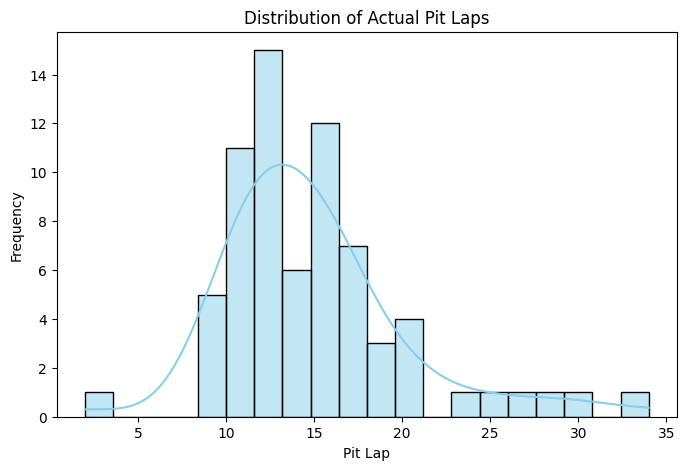

/tmp/ipython-input-3858977949.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='tyre_after_pit', data=df, palette='Set2')


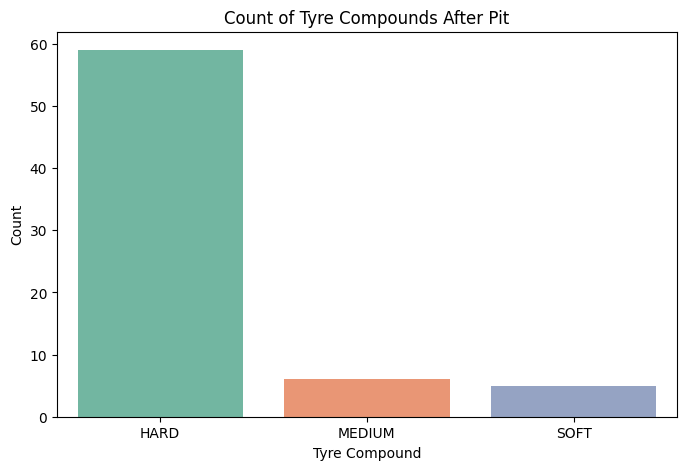

/tmp/ipython-input-3858977949.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='tyre_after_pit', y='avg_lap_time_before_pit', data=df, palette='Set3')


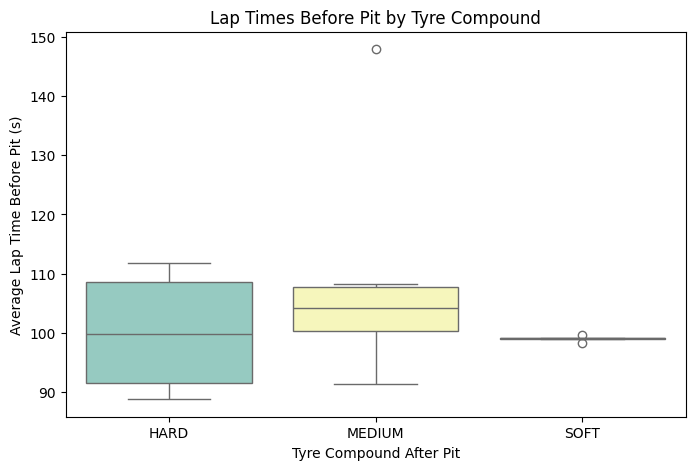

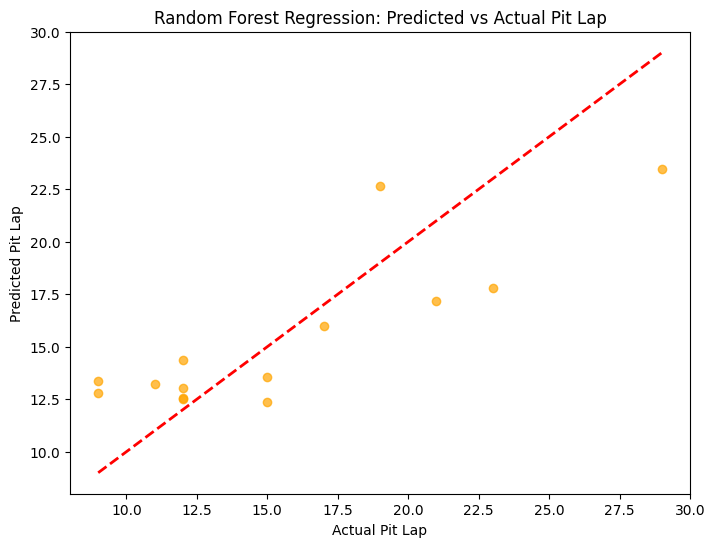

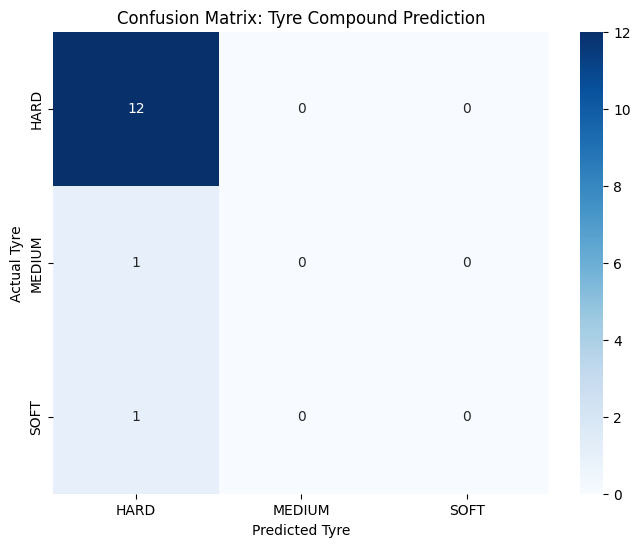

/tmp/ipython-input-3858977949.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='coolwarm')


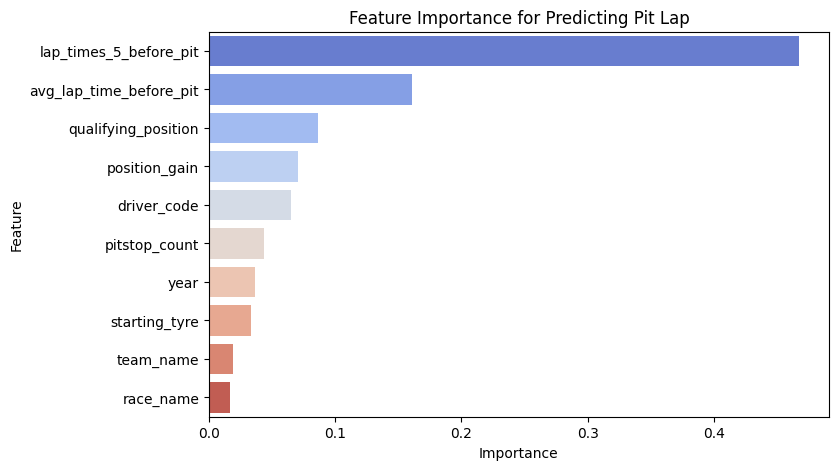

/tmp/ipython-input-3858977949.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='tyre_after_pit', y='position_gain', data=df, palette='Set1')


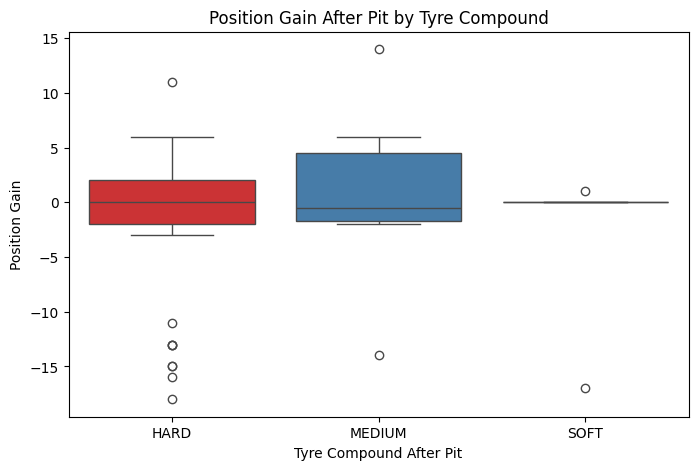

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------
# 1. Distribution of Pit Laps
# ----------------------------
plt.figure(figsize=(8,5))
sns.histplot(df['actual_pit_lap'], bins=20, kde=True, color='skyblue')
plt.title("Distribution of Actual Pit Laps")
plt.xlabel("Pit Lap")
plt.ylabel("Frequency")
plt.show()

# ----------------------------
# 2. Tyre Compound Counts
# ----------------------------
plt.figure(figsize=(8,5))
sns.countplot(x='tyre_after_pit', data=df, palette='Set2')
plt.title("Count of Tyre Compounds After Pit")
plt.xlabel("Tyre Compound")
plt.ylabel("Count")
plt.show()

# ----------------------------
# 3. Average Lap Time Before Pit by Tyre
# ----------------------------
plt.figure(figsize=(8,5))
sns.boxplot(x='tyre_after_pit', y='avg_lap_time_before_pit', data=df, palette='Set3')
plt.title("Lap Times Before Pit by Tyre Compound")
plt.xlabel("Tyre Compound After Pit")
plt.ylabel("Average Lap Time Before Pit (s)")
plt.show()

# ----------------------------
# 4. Predicted vs Actual Pit Lap (Regression Performance)
# ----------------------------
plt.figure(figsize=(8,6))
plt.scatter(y_test_lap, y_pred_lap, alpha=0.7, color='orange')
plt.plot([y_test_lap.min(), y_test_lap.max()], [y_test_lap.min(), y_test_lap.max()], 'r--', lw=2)
plt.xlabel("Actual Pit Lap")
plt.ylabel("Predicted Pit Lap")
plt.title("Random Forest Regression: Predicted vs Actual Pit Lap")
plt.show()

# ----------------------------
# 5. Confusion Matrix for Tyre Prediction
# ----------------------------
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_tyre, y_pred_tyre)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=tyre_encoder.classes_,
            yticklabels=tyre_encoder.classes_)
plt.xlabel("Predicted Tyre")
plt.ylabel("Actual Tyre")
plt.title("Confusion Matrix: Tyre Compound Prediction")
plt.show()

# ----------------------------
# 6. Feature Importance for Pit Lap Regression
# ----------------------------
importances = pit_lap_model.feature_importances_
feat_imp_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='coolwarm')
plt.title("Feature Importance for Predicting Pit Lap")
plt.show()

# ----------------------------
# 7. Position Gain vs Tyre Compound (Optional Insight)
# ----------------------------
plt.figure(figsize=(8,5))
sns.boxplot(x='tyre_after_pit', y='position_gain', data=df, palette='Set1')
plt.title("Position Gain After Pit by Tyre Compound")
plt.xlabel("Tyre Compound After Pit")
plt.ylabel("Position Gain")
plt.show()